In [1]:
print("Hello, World! ^_^ ")

Hello, World! ^_^ 


# Activate Environment and import necessary modules

In [2]:
!source /Users/amirejibiilia/Desktop/Thesis/new_venv/bin/activate

In [3]:
import time
import numpy as np
import pandas as pd 

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, train_test_split # Model evaluation
from sklearn.preprocessing import MinMaxScaler # Data normalization

from xgboost import XGBRegressor, DMatrix, plot_importance # XGBoost

import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

import matplotlib.dates as mdates
import optuna
from sklearn.metrics import mean_squared_error

2024-06-17 14:08:40.617719: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# data import
df_train = pd.read_excel("/Users/amirejibiilia/Desktop/Thesis/version_4.xlsx", index_col = 0) 
cols_list = list(df_train.columns) 

In [5]:
df_train.head().round(2)

,HousingIndex,Capitalisation,ExchangeRate,InterestRateOnDeposits,CPI,HouseAffordabilityIndex,RentIndex,MortgageRate
Date,,,,,,,,
2005-01-01,163.43,8.53,1.82,7.66,102.09,40.0,111.90,0.16
2005-02-01,159.72,9.56,1.83,7.49,100.32,40.0,122.59,0.16
2005-03-01,178.20,8.62,1.84,7.04,100.59,40.0,123.29,0.16
2005-04-01,183.23,8.81,1.83,7.08,100.42,40.0,129.64,0.16
2005-05-01,175.51,9.45,1.83,7.58,98.71,40.0,133.09,0.16


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 230 entries, 2005-01-01 to 2024-02-29
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   HousingIndex             230 non-null    float64
 1   Capitalisation           230 non-null    float64
 2   ExchangeRate             230 non-null    float64
 3   InterestRateOnDeposits   230 non-null    float64
 4   CPI                      230 non-null    float64
 5   HouseAffordabilityIndex  230 non-null    float64
 6   RentIndex                230 non-null    float64
 7   MortgageRate             230 non-null    float64
dtypes: float64(8)
memory usage: 16.2 KB


In [7]:
df_train.describe().round(2)

,HousingIndex,Capitalisation,ExchangeRate,InterestRateOnDeposits,CPI,HouseAffordabilityIndex,RentIndex,MortgageRate
count,230.00,230.00,230.00,230.00,230.00,230.00,230.00,230.00
mean,336.60,8.49,2.18,7.38,100.42,97.92,231.91,0.12
std,96.23,1.13,0.56,1.78,1.01,37.87,88.82,0.03
min,159.07,6.61,1.40,4.06,95.96,40.00,111.90,0.06
25%,267.76,7.71,1.68,5.84,99.86,62.14,170.51,0.09
50%,315.28,8.29,1.83,7.50,100.32,100.03,212.76,0.11
75%,386.71,9.11,2.66,8.57,100.86,134.87,262.56,0.16
max,566.67,11.95,3.44,11.66,104.19,155.52,497.86,0.17


# Exploratory Data Analysis

## display Missing values

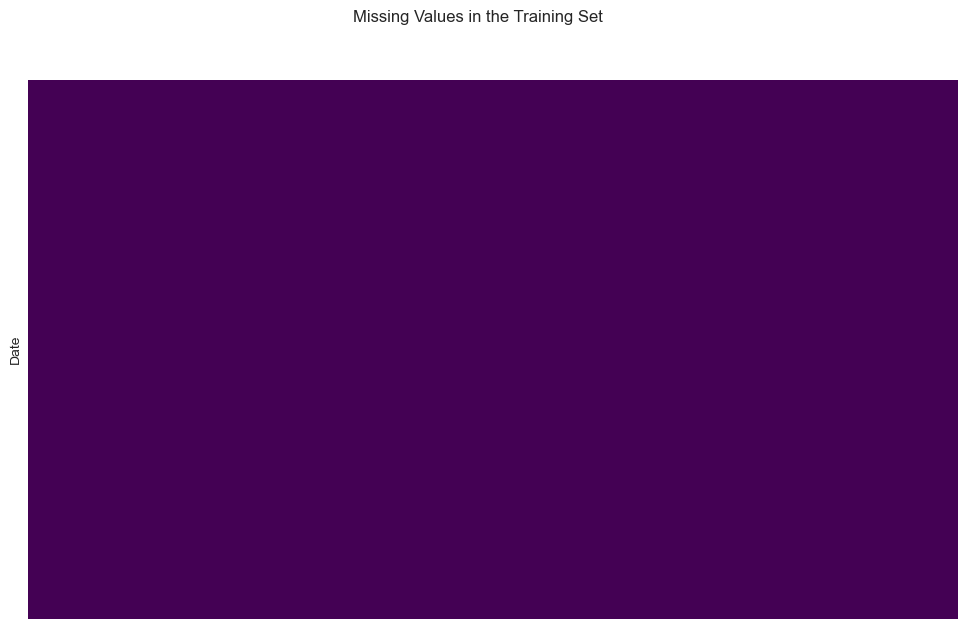

In [8]:
label_nas = []
for col in df_train.columns.tolist():
    if np.sum(df_train[col].isnull() ) != 0:
        label_nas.append(col)
    else:
        label_nas.append("")

plt.figure(figsize=(12,7))
plt.suptitle('Missing Values in the Training Set')
sns.heatmap(df_train.isnull(), yticklabels=False, xticklabels=label_nas ,cbar = False, cmap='viridis')
plt.show()

## Data Correlation Analysis

In [9]:
# Correlation matrix
corr_mat = df_train.corr()

# Find most Correlated features relative to HousingIndex
corr_mat.sort_values(by=["HousingIndex"], ascending = False, inplace = True)
# print(corr_mat.HousingIndex.round(2))
data_frame_corr_mat = pd.DataFrame(corr_mat.HousingIndex.round(2))
data_frame_corr_mat

,HousingIndex
HousingIndex,1.00
RentIndex,0.91
HouseAffordabilityIndex,0.84
ExchangeRate,0.84
Capitalisation,0.29
CPI,0.01
InterestRateOnDeposits,-0.35
MortgageRate,-0.71


In [10]:
#Correlation matrix between features
corr_mat = df_train.corr()

<Axes: >

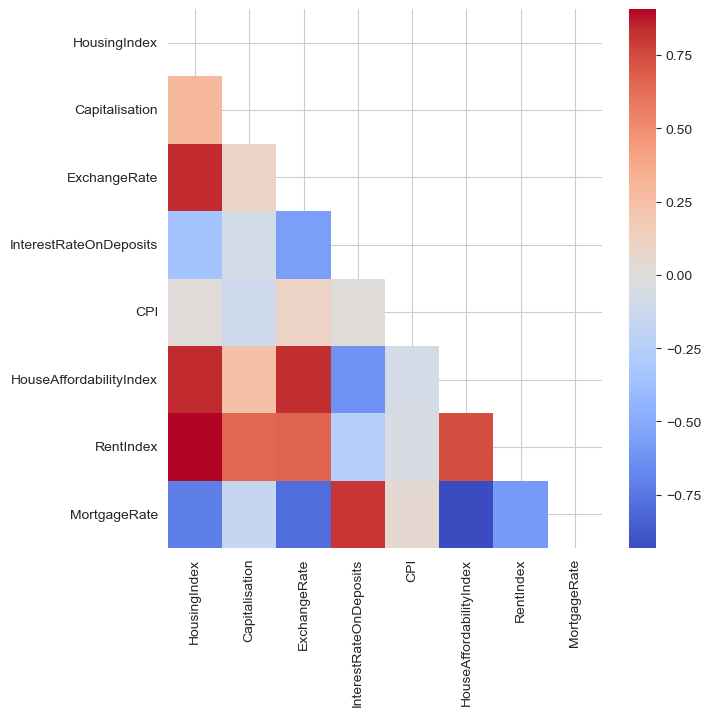

In [11]:
#Plot the heatmap with seaborn
plt.figure(figsize=(7,7)) 

mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_mat, mask=mask, cmap = 'coolwarm',
        xticklabels=corr_mat.columns,
        yticklabels=corr_mat.columns)

## Skewness

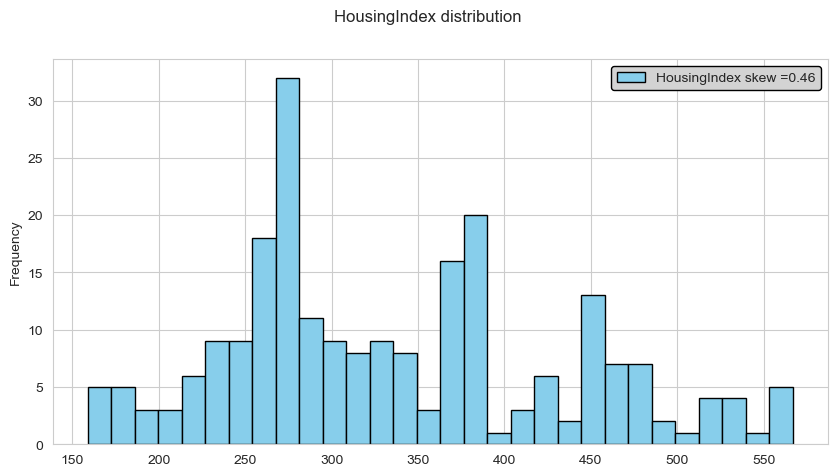

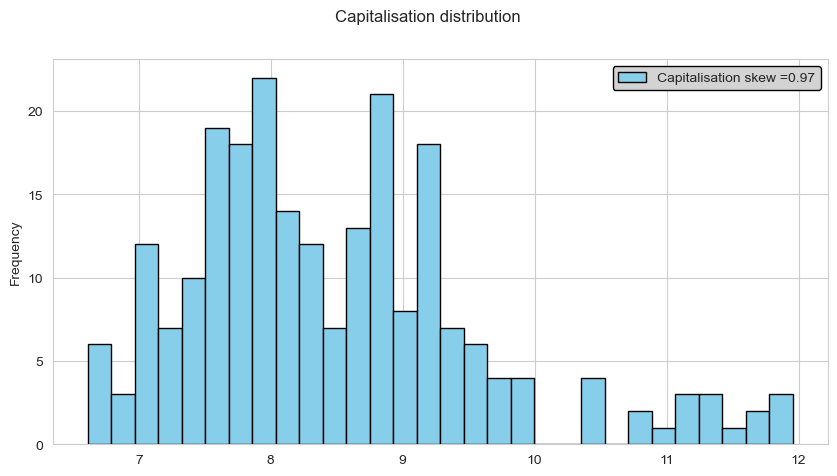

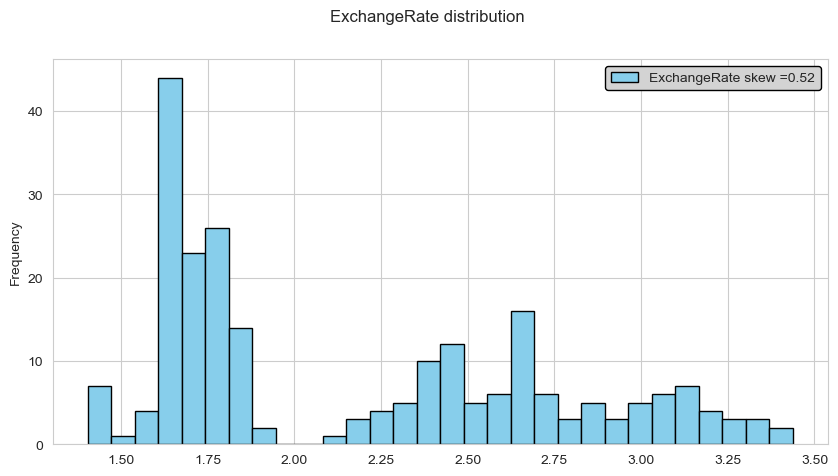

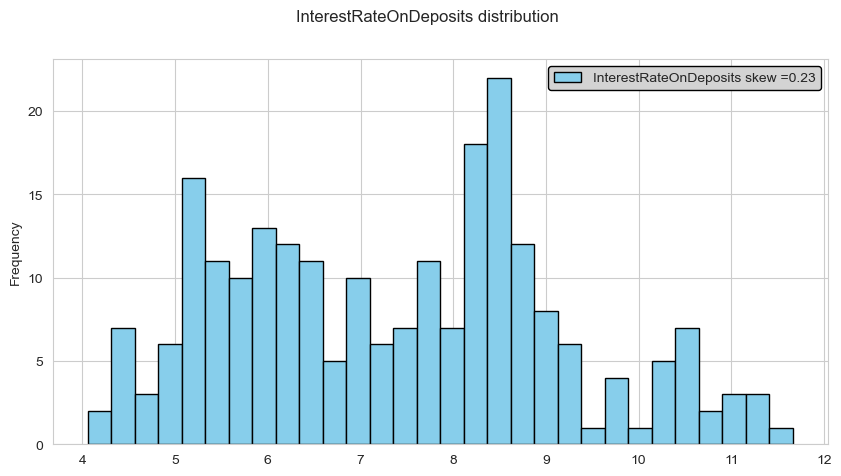

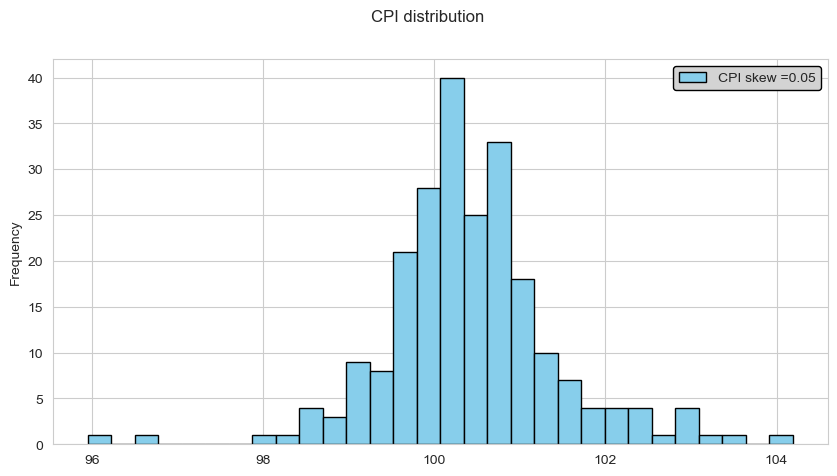

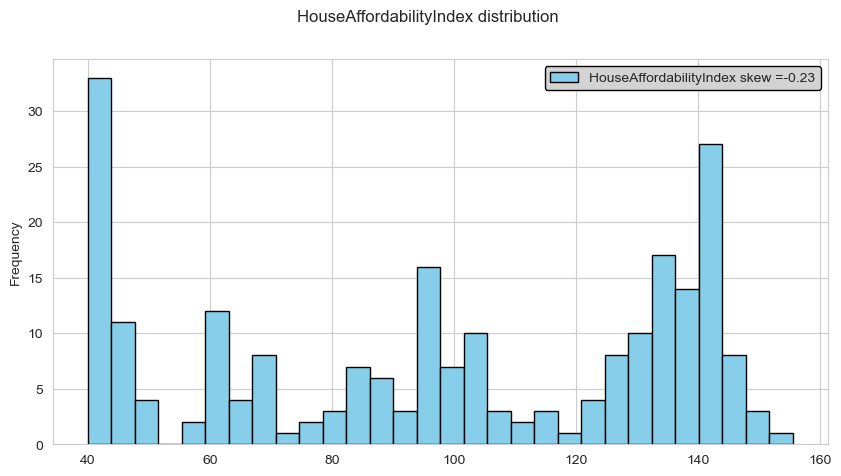

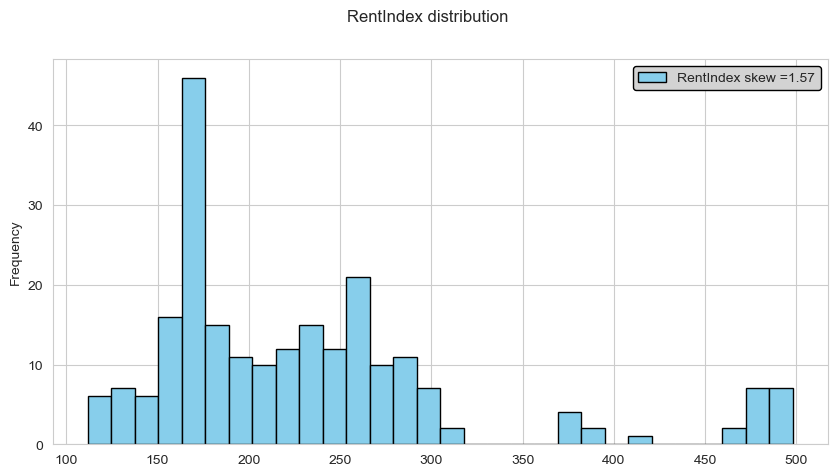

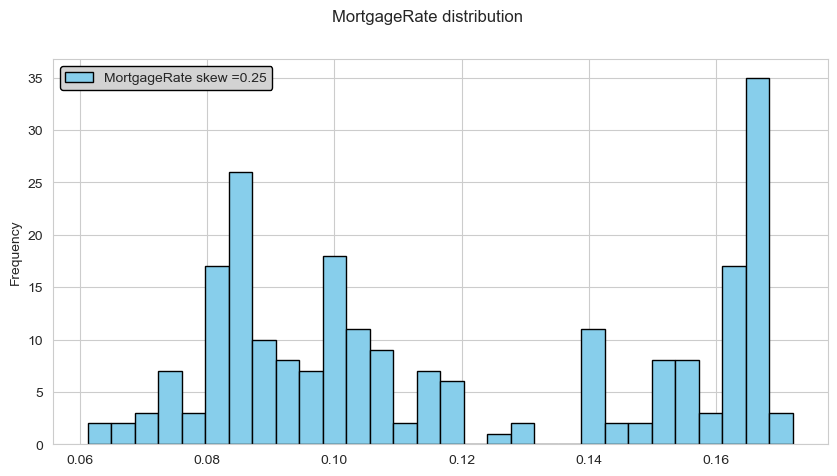

In [12]:
# Check the skewness of HousingIndex
for col in cols_list:
    plt.figure(figsize=(10, 5))
    skewness = df_train[col].skew()
    df_train[col].plot.hist(edgecolor='black', bins=30, 
                            label=col + ' skew =' + str(round(skewness, 2)), 
                            color='skyblue')
    plt.suptitle("{} distribution".format(col))
    plt.legend(edgecolor='black', facecolor='lightgrey', framealpha=1)
    plt.show()



## Box plots

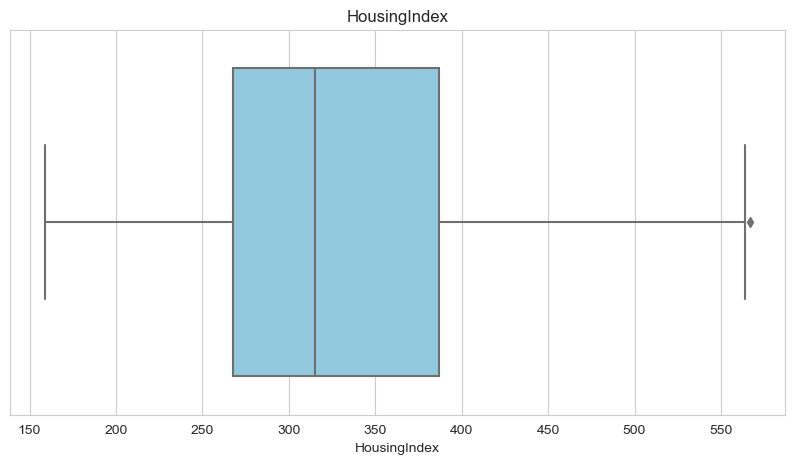

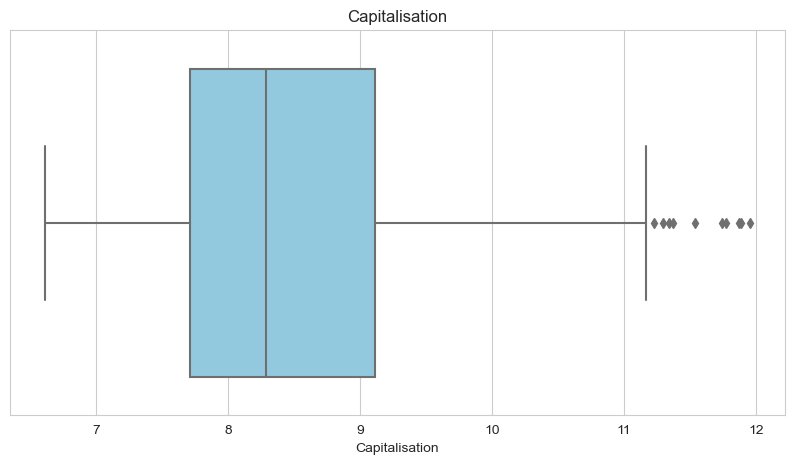

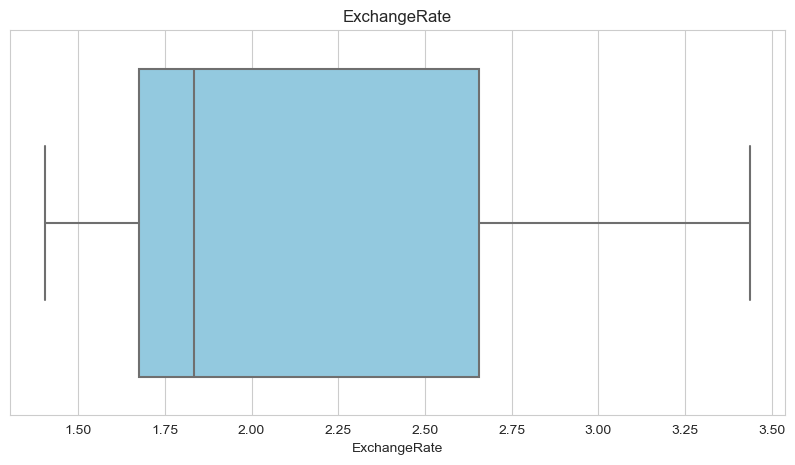

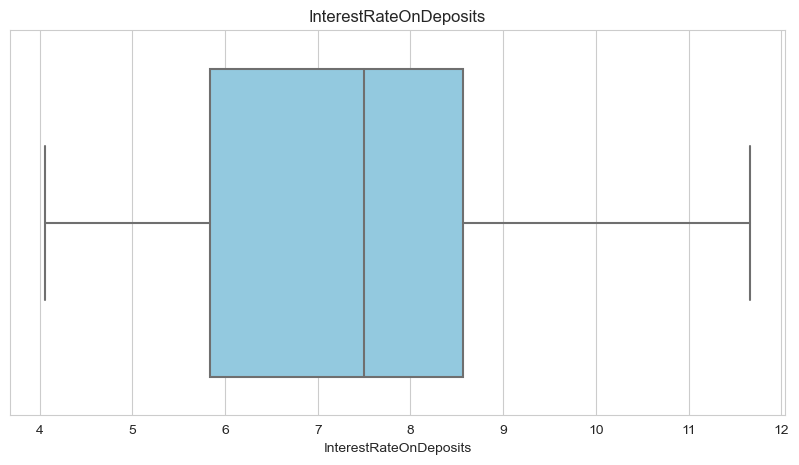

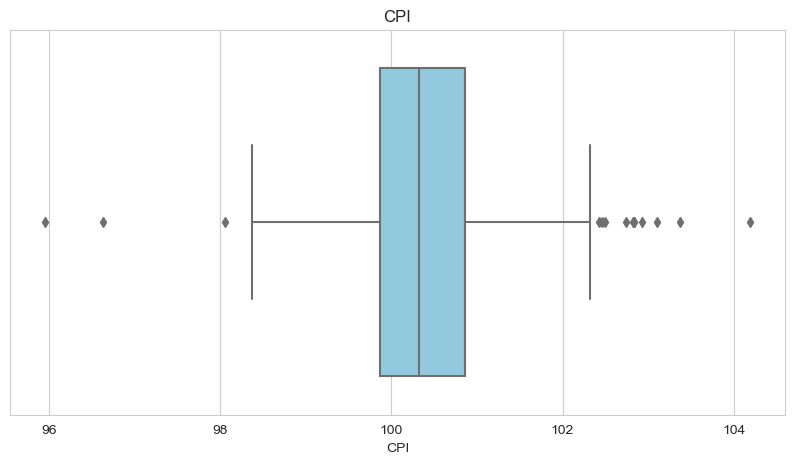

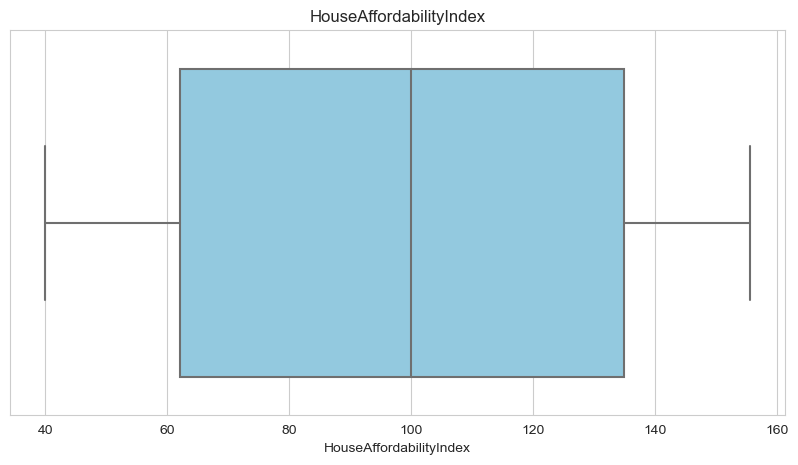

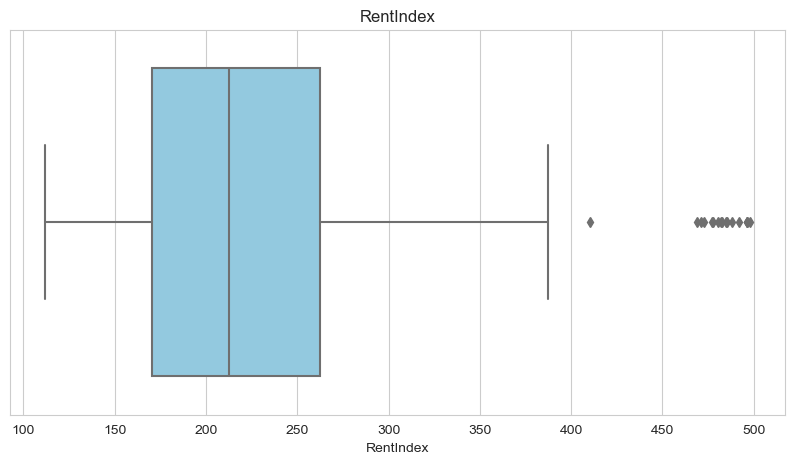

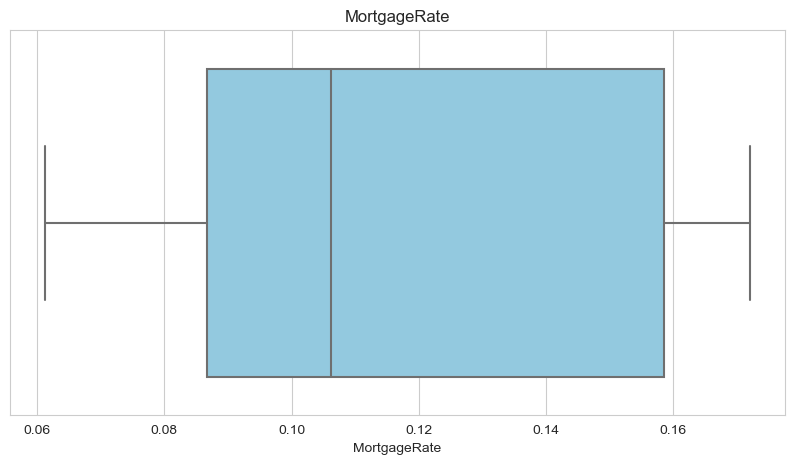

In [13]:
for col in cols_list:
    plt.figure(figsize=(10, 5))
    ax = sns.boxplot(x=col, data=df_train, color='skyblue')
    ax.set_title(col)
    plt.show()

## Features and Trend

In [14]:
df_train_vis = pd.read_excel("/Users/amirejibiilia/Desktop/Thesis/version_4.xlsx") 
cols_list_vis = list(df_train_vis.columns) 

In [15]:
# Convert 'Date' column to matplotlib numeric format
df_train_vis['Date'] = df_train_vis['Date'].apply(mdates.date2num)

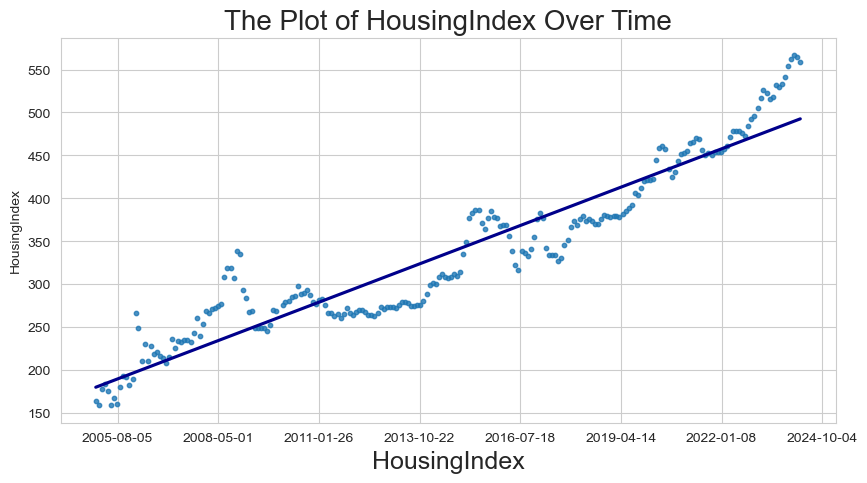

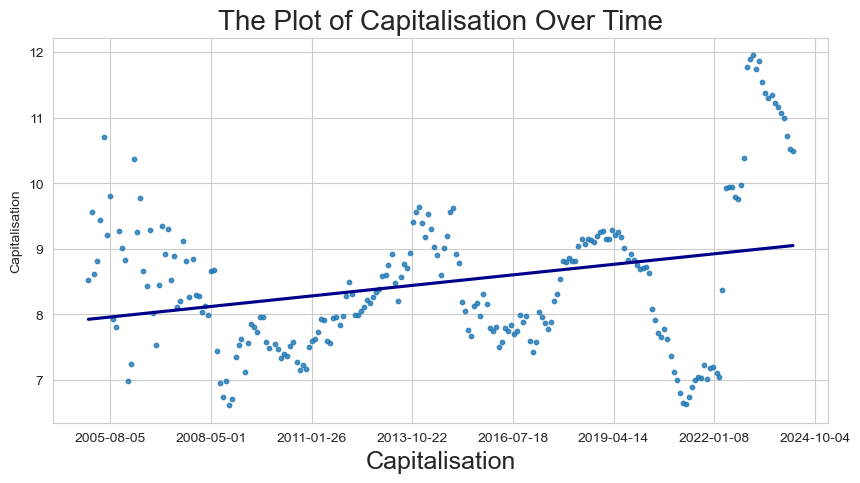

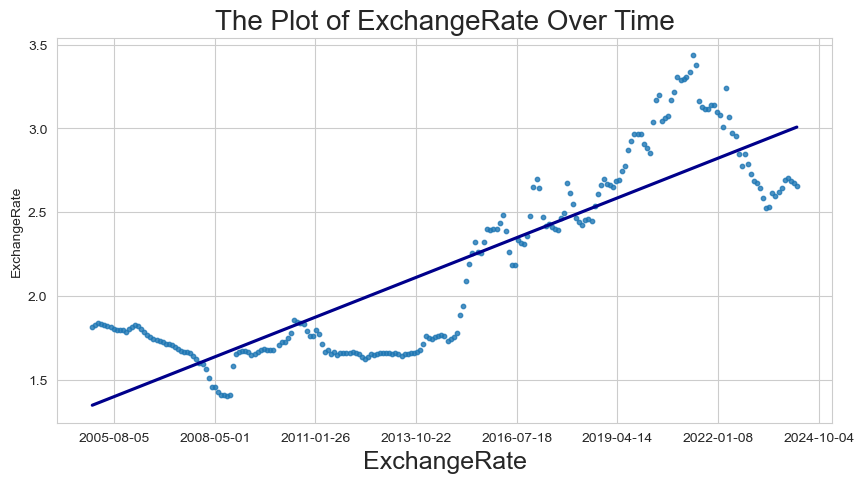

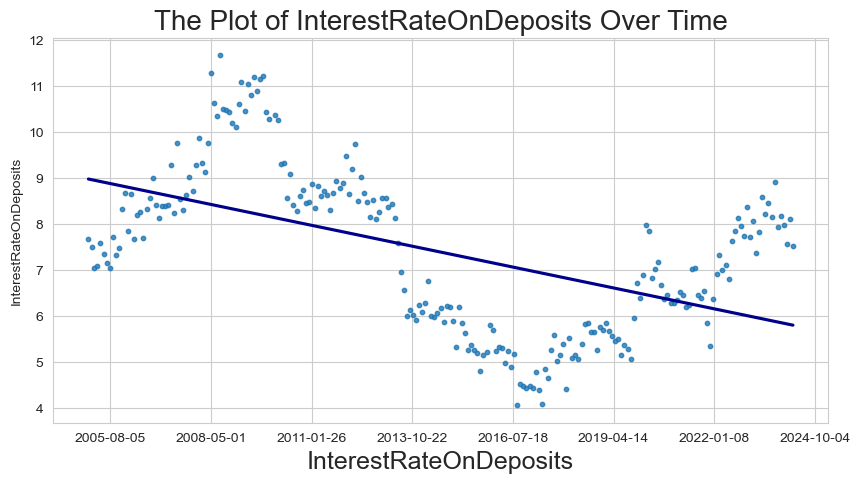

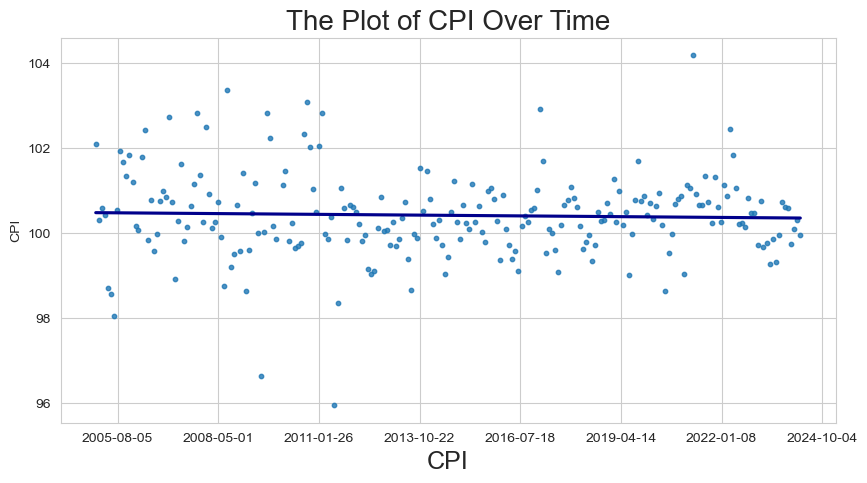

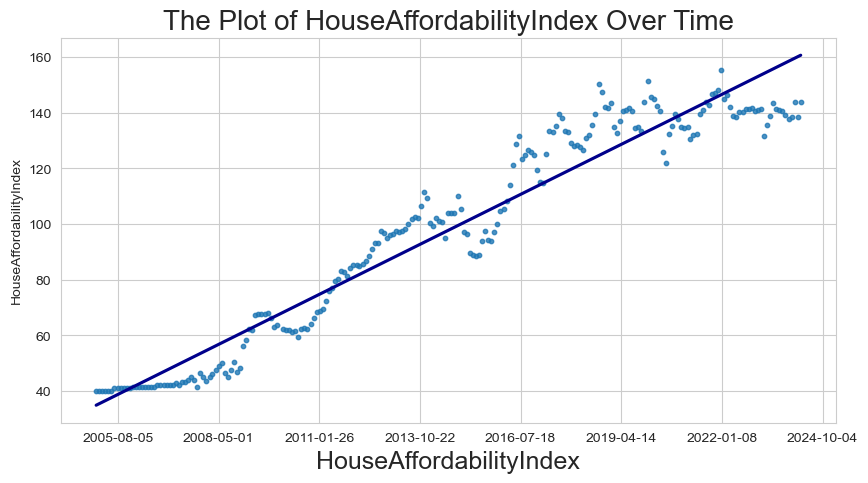

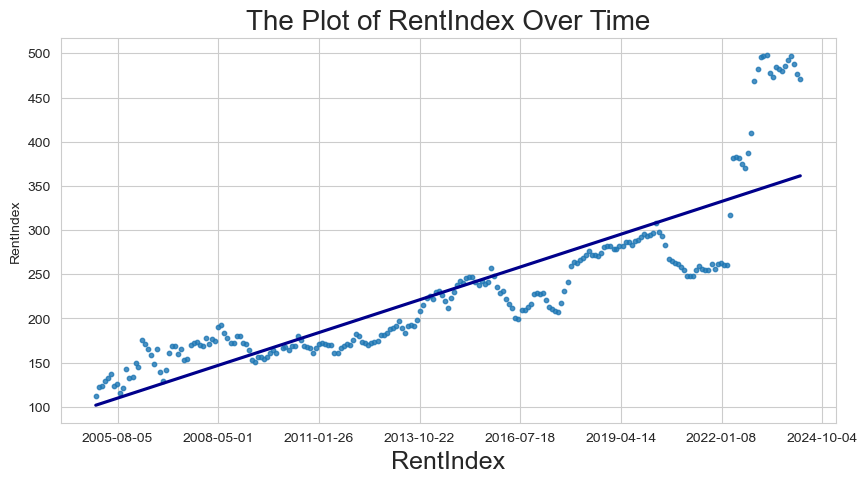

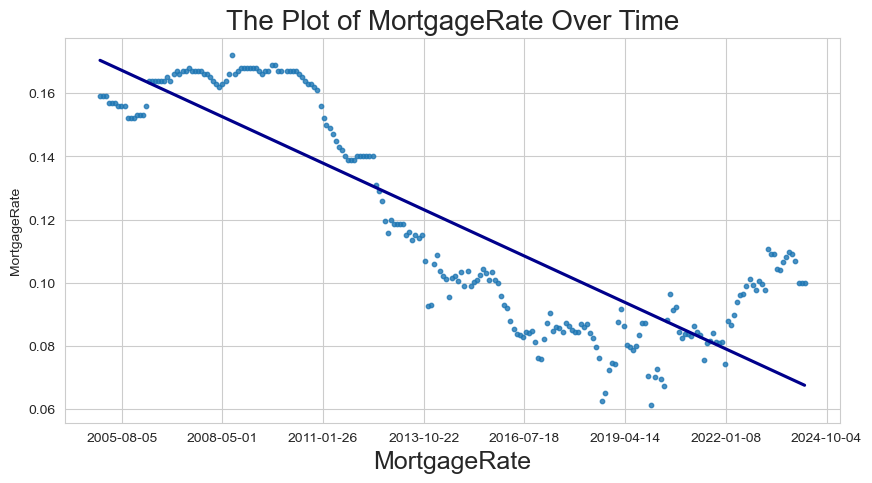

In [16]:
for col in cols_list:
    x_axis = 'Date'
    y_axis = col

    # Proceed with plotting
    plt.figure(figsize=(10, 5))
    sns.regplot(x=x_axis, y=y_axis, data=df_train_vis, fit_reg=True, ci=None, 
                scatter_kws={'s': 10},               # The size of the scatter points
                line_kws={'color': 'darkblue'})       # The color of the regression line
    plt.title('The Plot of {} Over Time'.format(y_axis), fontsize=20)
    plt.xlabel(format(y_axis), fontsize=18)
    plt.grid(True)

    # Customize x-axis tick labels to display dates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=0)
    plt.show()


## HousingIndex vs other Features

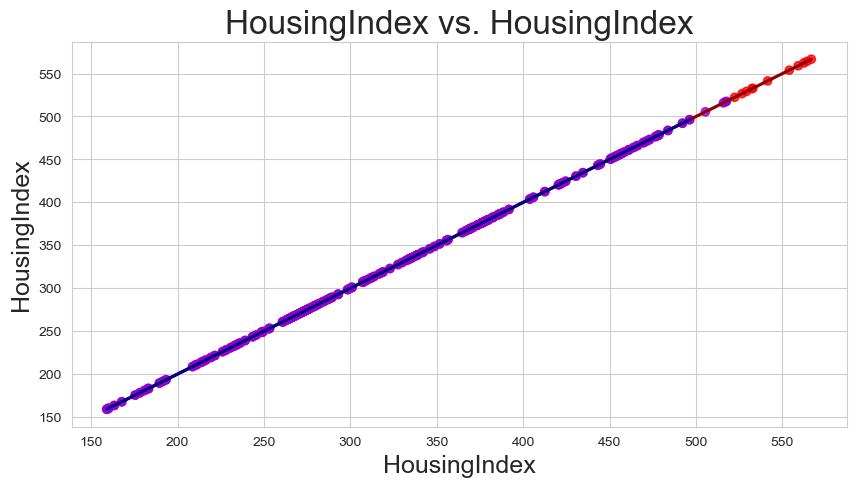

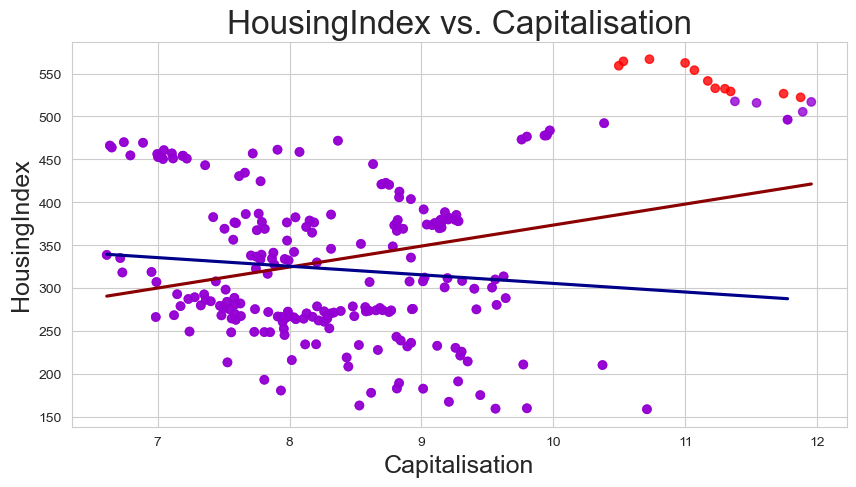

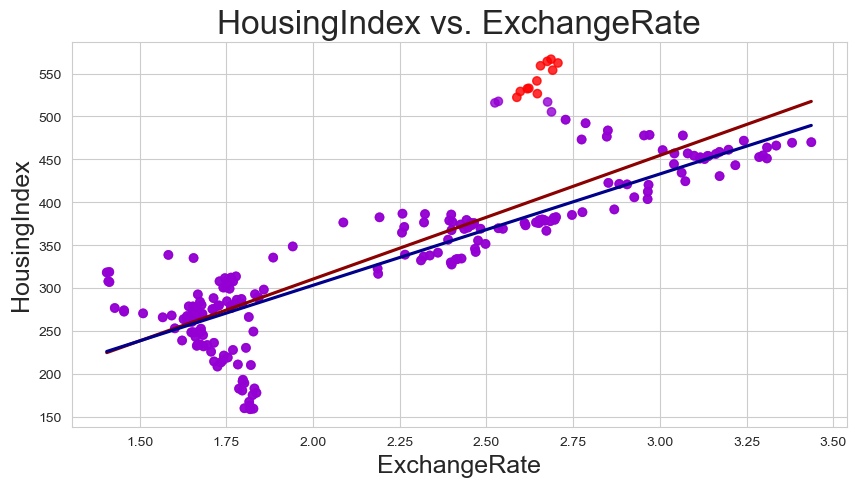

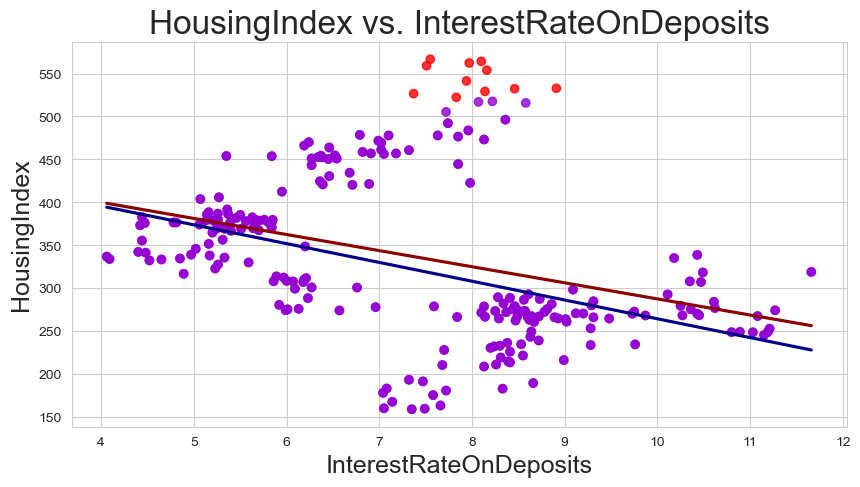

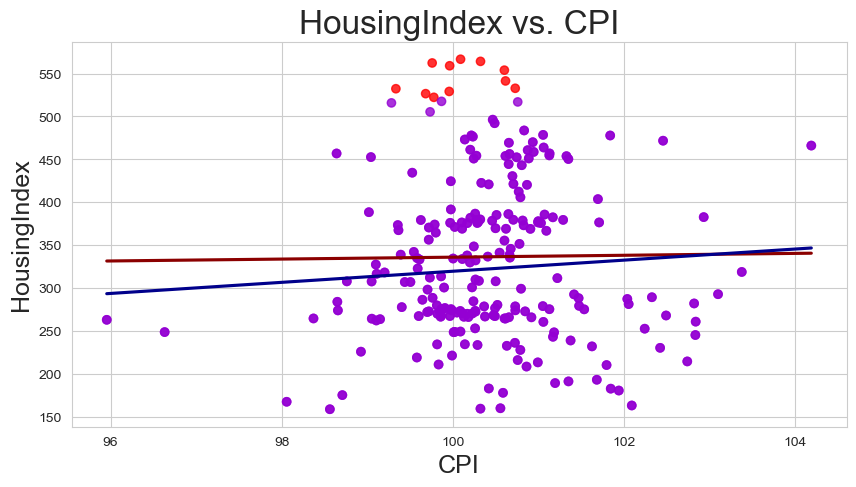

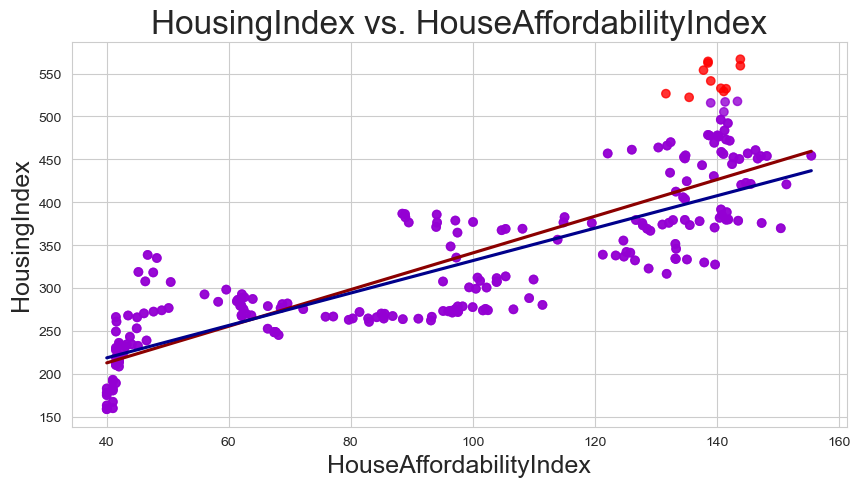

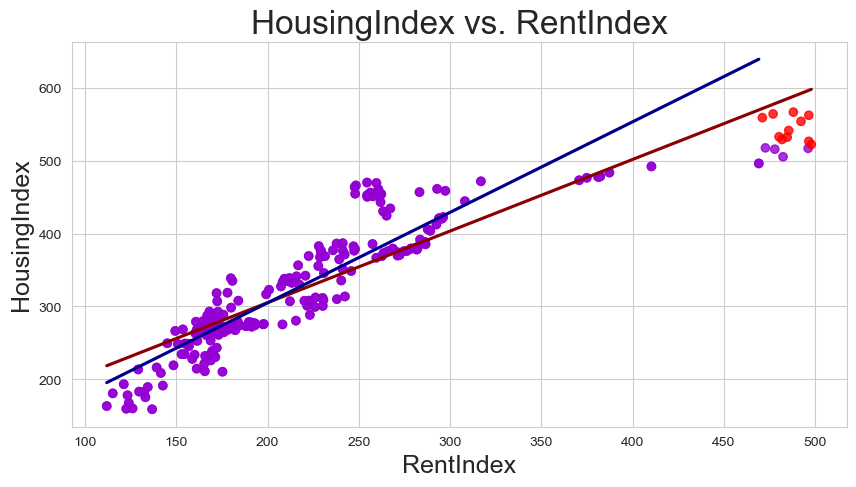

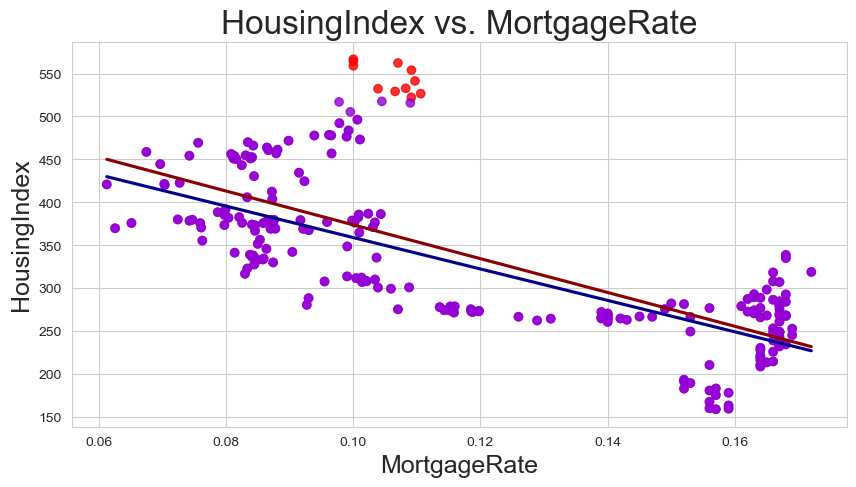

In [17]:
# Displays A Scatter Plot with Regression Line + Outliers in Red (Outliers are defined as >520 that is 98% percentile)

for col in cols_list:
    x_axis = col
    y_axis = 'HousingIndex'
    value = df_train[y_axis] > 520
    value2 = df_train[y_axis][:-15] > 520

    plt.figure(figsize=(10, 5))
    sns.regplot(x=df_train[x_axis], y=df_train[y_axis], fit_reg=True, ci = None,
                scatter_kws={'facecolors': np.where(value, "red", 'darkviolet'),
                             'edgecolor': np.where(value, "red", 'darkviolet')},
                line_kws={'color': 'darkred'})

    sns.regplot(x=df_train[x_axis][:-15], y=df_train[y_axis][:-15], fit_reg=True,ci = None,
                scatter_kws={'facecolors': np.where(value2, "red", 'darkviolet'),
                             'edgecolor': np.where(value2, "red", 'darkviolet')},
                line_kws={'color': 'darkblue'})

    plt.title('HousingIndex vs. {}'.format(x_axis), fontsize=24)
    plt.xlabel(x_axis, fontsize=18)
    plt.ylabel('HousingIndex', fontsize=18)
    # plt.savefig('figures/Standardised_SalePrice_GrLivArea.png')

plt.show()


# XGBoost

## XGBoost - Data Preparation

In [18]:
df_train.head().round(2)

,HousingIndex,Capitalisation,ExchangeRate,InterestRateOnDeposits,CPI,HouseAffordabilityIndex,RentIndex,MortgageRate
Date,,,,,,,,
2005-01-01,163.43,8.53,1.82,7.66,102.09,40.0,111.90,0.16
2005-02-01,159.72,9.56,1.83,7.49,100.32,40.0,122.59,0.16
2005-03-01,178.20,8.62,1.84,7.04,100.59,40.0,123.29,0.16
2005-04-01,183.23,8.81,1.83,7.08,100.42,40.0,129.64,0.16
2005-05-01,175.51,9.45,1.83,7.58,98.71,40.0,133.09,0.16


## Hyperparameters Tuning of XGBoost 

In [19]:
# Data split
y_full = df_train['HousingIndex'][:-15]
X_full = df_train.drop(columns=["HousingIndex"])[:-15]

y_test = df_train['HousingIndex'][-15:]
X_test = df_train.drop(columns=["HousingIndex"])[-15:]

In [20]:
# Define objective function for Optuna with Walk-Forward Validation
def objective(trial):
    # Define hyperparameters to optimize
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 5),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0)
    }

    # Create XGBoost model with the suggested parameters
    model = XGBRegressor(**params, objective='reg:squarederror', random_state=123)

    # Walk-Forward Validation
    initial_train_size = int(len(X_full) * 0.6)
    test_size = int(len(X_full) * 0.1)
    n_records = len(X_full)
    rmse_scores = []

    for i in range(initial_train_size, n_records, test_size):
        train_end = i
        test_end = i + test_size if (i + test_size) < n_records else n_records

        X_train_split, X_test_split = X_full[:train_end], X_full[train_end:test_end]
        y_train_split, y_test_split = y_full[:train_end], y_full[train_end:test_end]

        model.fit(X_train_split, y_train_split)
        y_pred = model.predict(X_test_split)
        rmse = np.sqrt(mean_squared_error(y_test_split, y_pred))
        rmse_scores.append(rmse)

    mean_rmse = np.mean(rmse_scores)
    return mean_rmse

# Create study object and optimize hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1)                 # ეს თუ 1 არ არის ეგრევე ოვერფიტინგზე მიდის

# Get best hyperparameters
best_params = study.best_params

# Update the model with the best hyperparameters
model = XGBRegressor(**best_params, objective='reg:squarederror', random_state=123)

# Train the model on the full training data
model.fit(X_full, y_full)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test RMSE: {test_rmse}")


[I 2024-06-17 14:08:58,570] A new study created in memory with name: no-name-8194c094-b369-427c-90cf-3cb184ac26a4
/var/folders/fb/0f4v33f515vfq6921ss69f180000gn/T/ipykernel_29306/672020004.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/var/folders/fb/0f4v33f515vfq6921ss69f180000gn/T/ipykernel_29306/672020004.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
/var/folders/fb/0f4v33f515vfq6921ss69f180000gn/T/ipykernel_29306/672020004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0.

Test RMSE: 124.03521056181908


In [21]:
# Best Params Themselves!
best_params
df_parameters_nicely = pd.DataFrame([best_params])
df_parameters_nicely

,max_depth,learning_rate,n_estimators,gamma,min_child_weight,subsample,colsample_bytree,reg_lambda,reg_alpha
0,5,0.011883,795,0.01926,20,0.634113,0.516021,8.790991e-07,0.000146


## Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

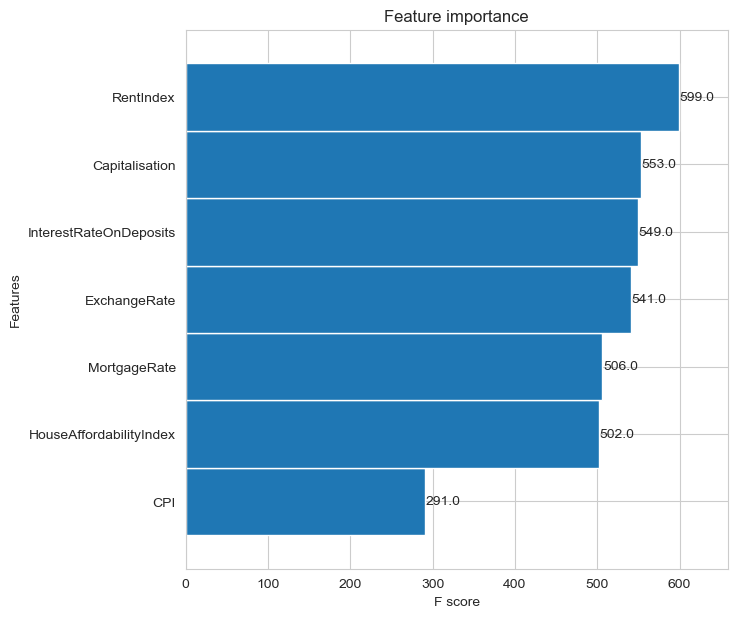

In [22]:
# Plot feature importance
figsize=(7,7)
fig, ax = plt.subplots(1,1,figsize=figsize)
plot_importance(model, ax=ax,height = 1)

## Prediction by XGBoost

In [23]:
# predict
full_predictions = model.predict(X_full).flatten()
test_predictions = model.predict(X_test).flatten()

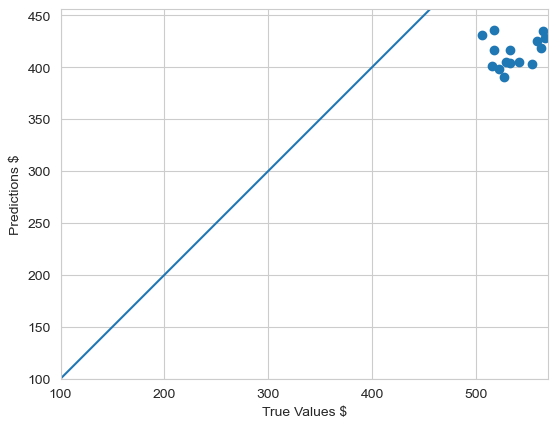

In [24]:
# scatter plot of True vs Predicted values - Test set
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values $')
plt.ylabel('Predictions $')
plt.axis('equal')
plt.axis('square')
plt.xlim([100,plt.xlim()[1]])
plt.ylim([100,plt.ylim()[1]])
_ = plt.plot([0, 1000], [0, 1000])



## XGboost - HousingIndex Prediction 

In [25]:
# For training & validation sets so called - X_full

In [26]:
c = pd.DataFrame([y_full], index = ['Date']).T.reset_index(drop=True)
c.rename(columns={'Date': 'date_full'}, inplace=True)
d = pd.DataFrame([full_predictions], index = ['Date']).T
d.rename(columns={'Date': 'date_full_prediction'}, inplace=True)

In [27]:
to_plot_full_data = pd.concat([c,d], axis = 1)

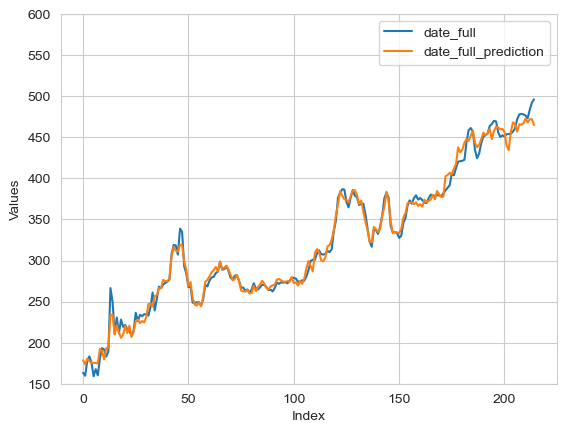

In [28]:
# Plot over index
plt.plot(to_plot_full_data.index, to_plot_full_data['date_full'], label='date_full')
plt.plot(to_plot_full_data.index, to_plot_full_data['date_full_prediction'], label='date_full_prediction')

# Set y-axis range
plt.ylim(150, 600)

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()

# Show plot
plt.show()


In [29]:
# For Test set

In [30]:
a = pd.DataFrame([y_test], index = ['Date']).T.reset_index(drop=True)
a.rename(columns={'Date': 'date_test'}, inplace=True)
b = pd.DataFrame([test_predictions], index = ['Date']).T
b.rename(columns={'Date': 'date_prediction'}, inplace=True)

In [31]:
to_plot_data = pd.concat([a,b], axis = 1)
to_plot_data

,date_test,date_prediction
0,505.391378,431.052765
1,516.948317,435.841858
2,526.581209,390.703979
3,522.302736,398.187775
4,515.821737,401.536713
5,517.619202,416.758759
6,532.317906,416.300446
7,529.150824,404.874695
8,532.834361,404.148560
9,541.391305,405.322327


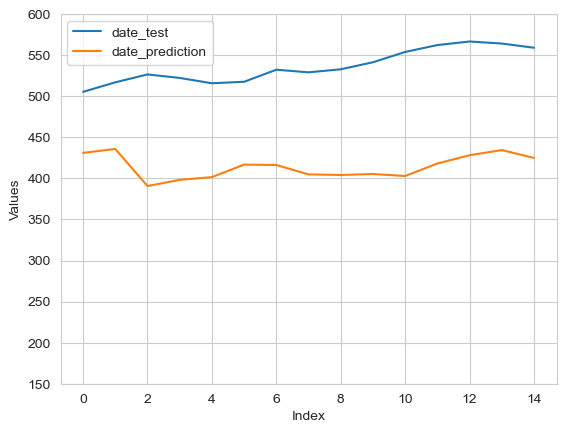

In [32]:
# Plot over index
plt.plot(to_plot_data.index, to_plot_data['date_test'], label='date_test')
plt.plot(to_plot_data.index, to_plot_data['date_prediction'], label='date_prediction')

# Set y-axis range
plt.ylim(150, 600)

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()

# Show plot
plt.show()


In [33]:
# For Data Combined = full + test

In [34]:
# Rename columns to the same names
to_plot_full_data.columns = ['real', 'predict']
to_plot_data.columns = ['real', 'predict']

# Concatenating the dataframes vertically
concatenated_data = pd.concat([to_plot_full_data, to_plot_data], axis=0, ignore_index=True)
full_with_test = pd.DataFrame(concatenated_data)
full_with_test

,real,predict
0,163.432655,178.522049
1,159.721115,173.708511
2,178.196334,180.500870
3,183.228683,177.389709
4,175.511441,175.794846
...,...,...
225,553.941913,402.914459
226,562.321642,418.118256
227,566.672267,428.220245
228,564.176069,434.464050


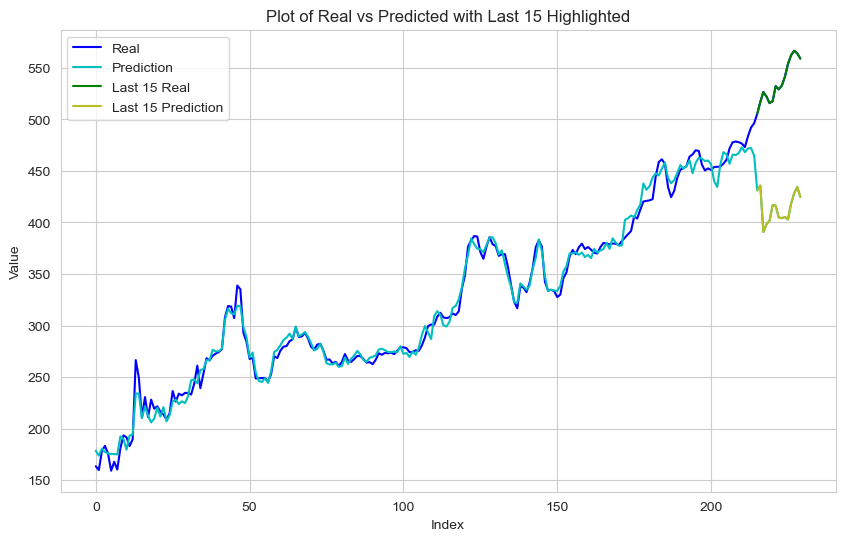

In [35]:
# Plotting the entire 'real' and 'predict' data
plt.figure(figsize=(10, 6))
plt.plot(full_with_test.index, full_with_test['real'], linestyle='-', color='b', label='Real')
plt.plot(full_with_test.index, full_with_test['predict'], linestyle='-', color='c', label='Prediction')

# Highlighting the last 15 values with different colors
last_15_real = full_with_test['real'].tail(15)
last_15_predict = full_with_test['predict'].tail(15)
last_15_index = full_with_test.index[-15:]

plt.plot(last_15_index, last_15_real, linestyle='-', color='g', label='Last 15 Real')
plt.plot(last_15_index, last_15_predict, linestyle='-', color='tab:olive', label='Last 15 Prediction')

# Adding title and labels
plt.title('Plot of Real vs Predicted with Last 15 Highlighted')
plt.xlabel('Index')
plt.ylabel('Value')

# Adding a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

## MSE of XGBoost

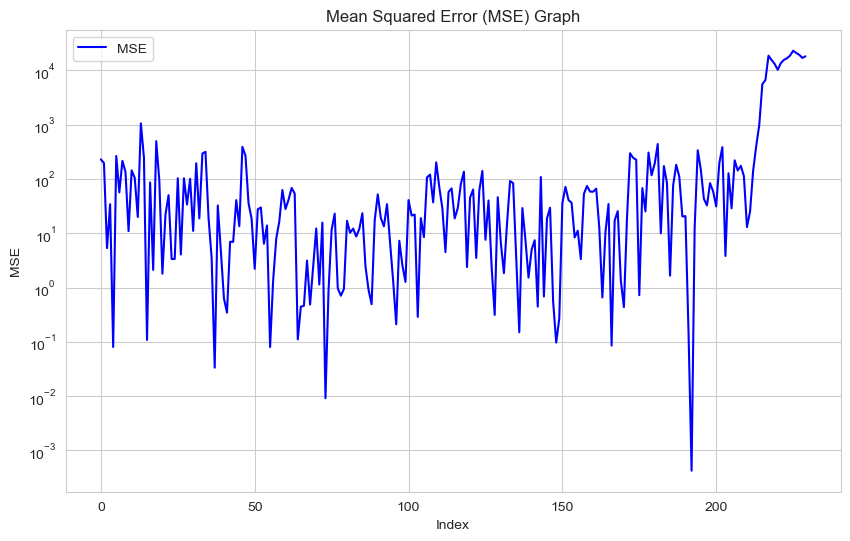

In [36]:
# Calculate MSE for each point
full_with_test['mse'] = (full_with_test['real'] - full_with_test['predict'])**2

# Plotting the MSE data with logarithmic y-axis
plt.figure(figsize=(10, 6))
plt.plot(full_with_test.index, full_with_test['mse'], linestyle='-', color='b', label='MSE')
plt.yscale('log')

# Adding title and labels
plt.title('Mean Squared Error (MSE) Graph')
plt.xlabel('Index')
plt.ylabel('MSE')

# Setting y-axis limits
plt.ylim=[1e-2,1e2]

# Adding a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

# LSTM Autoencoder - Anomaly Detection Approach

## LSTM - Data Preparation

In [37]:
# # Data normalization
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(df_train[:-15])
X_test = scaler.transform(df_train[-15:])

In [38]:
# Reshape for LSTM
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

## Hyperparameters Tuning of LSTM

In [39]:
# List to store hyperparameters, validation loss, and trial histories of each trial
all_trial_params = []
all_trial_val_losses = []
all_trial_histories = []  # Added to store trial histories

In [40]:
# Objective Function

def objective(trial):
    global all_trial_params, all_trial_val_losses, all_trial_histories  # Access the global lists
    
    # Define the hyperparameters to optimize
    lstm1_units = trial.suggest_int('lstm1_units', 4, 31)
    lstm2_units = trial.suggest_int('lstm2_units', 4, 16)
    regularizer_l2 = trial.suggest_uniform('regularizer_l2', 0.0, 0.1)
    
    # Build the model
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    L1 = LSTM(lstm1_units, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(regularizer_l2))(inputs)
    L2 = LSTM(lstm2_units, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X_train.shape[1])(L2)
    L4 = LSTM(lstm2_units, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(lstm1_units, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X_train.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    
    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Fixed learning rate
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Train-validation split based on time series data
    split_index = int(0.8 * len(X_train))  # Use first 80% for training
    X_train_split = X_train[:split_index]
    X_val_split = X_train[split_index:]
    
    # Train the model
    trial_history = model.fit(X_train_split, X_train_split, epochs=100, batch_size=10, 
                              validation_data=(X_val_split, X_val_split))
    
    # Get the validation loss
    val_loss = trial_history.history['val_loss'][-1]
    
    # Store hyperparameters, validation loss, and trial history
    all_trial_params.append((lstm1_units, lstm2_units))
    all_trial_val_losses.append(val_loss)
    all_trial_histories.append(trial_history)  # Store the history
    
    return val_loss

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1) #used to be 200 but for now it is 1

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-06-17 14:09:20,530] A new study created in memory with name: no-name-0a97aa6a-717f-41e2-90b2-e98e6d8e818a
/var/folders/fb/0f4v33f515vfq6921ss69f180000gn/T/ipykernel_29306/4272563787.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  regularizer_l2 = trial.suggest_uniform('regularizer_l2', 0.0, 0.1)
2024-06-17 14:09:20.639361: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
18/18 [==============================] - 7s 60ms/step - loss: 1.1359 - val_loss: 1.1914
Epoch 2/100
18/18 [==============================] - 0s 9ms/step - loss: 0.9443 - val_loss: 1.0105
Epoch 3/100
18/18 [==============================] - 0s 9ms/step - loss: 0.7824 - val_loss: 0.8583
Epoch 4/100
18/18 [==============================] - 0s 9ms/step - loss: 0.6463 - val_loss: 0.7290
Epoch 5/100
18/18 [==============================] - 0s 11ms/step - loss: 0.5316 - val_loss: 0.6181
Epoch 6/100
18/18 [==============================] - 0s 11ms/step - loss: 0.4338 - val_loss: 0.5211
Epoch 7/100
18/18 [==============================] - 0s 10ms/step - loss: 0.3490 - val_loss: 0.4337
Epoch 8/100
18/18 [==============================] - 0s 10ms/step - loss: 0.2741 - val_loss: 0.3521
Epoch 9/100
18/18 [==============================] - 0s 10ms/step - loss: 0.2102 - val_loss: 0.2822
Epoch 10/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1678 - val_loss: 0.2448
Ep

18/18 [==============================] - 0s 9ms/step - loss: 0.0380 - val_loss: 0.1401
Epoch 83/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0364 - val_loss: 0.1376
Epoch 84/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0345 - val_loss: 0.1312
Epoch 85/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0320 - val_loss: 0.1223
Epoch 86/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0291 - val_loss: 0.1170
Epoch 87/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0270 - val_loss: 0.1088
Epoch 88/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0250 - val_loss: 0.0999
Epoch 89/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0229 - val_loss: 0.0935
Epoch 90/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0213 - val_loss: 0.0868
Epoch 91/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0196 - val_loss: 0.0809
Epoch 92/100


[I 2024-06-17 14:09:45,823] Trial 0 finished with value: 0.05627909302711487 and parameters: {'lstm1_units': 19, 'lstm2_units': 10, 'regularizer_l2': 0.06924138941213477}. Best is trial 0 with value: 0.05627909302711487.


Best hyperparameters: {'lstm1_units': 19, 'lstm2_units': 10, 'regularizer_l2': 0.06924138941213477}


In [41]:
#Best Parameters Themselves!
best_params_df = pd.DataFrame([best_params])
best_params_df

,lstm1_units,lstm2_units,regularizer_l2
0,19,10,0.069241


## Parameters Optimization Graphs

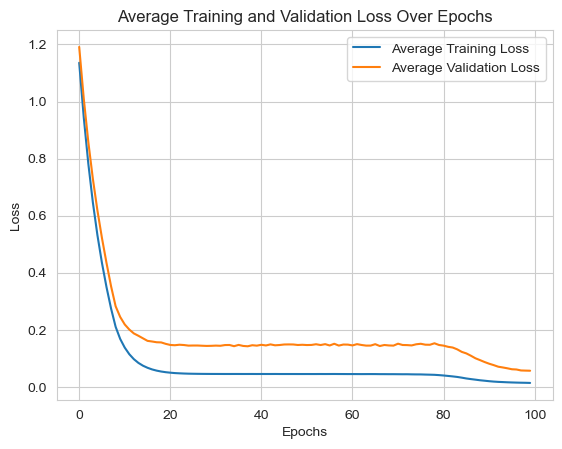

In [42]:
# Calculate average training and validation loss over all trials at each epoch
avg_train_loss = np.mean([trial_history.history['loss'] for trial_history in all_trial_histories], axis=0)
avg_val_loss = np.mean([trial_history.history['val_loss'] for trial_history in all_trial_histories], axis=0)

# Plot average training and validation loss
plt.plot(avg_train_loss, label='Average Training Loss')
plt.plot(avg_val_loss, label='Average Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [43]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# # Function to plot 3D visualization
# def plot_3d_val_losses(params, val_losses):
#     fig = plt.figure(figsize=(14, 10))
#     ax = fig.add_subplot(111, projection='3d')
    
#     lstm1_units = [param[0] for param in params]
#     lstm2_units = [param[1] for param in params]
    
#     sc = ax.scatter(lstm1_units, lstm2_units, val_losses, c=val_losses, cmap='viridis', marker='o')
    
#     ax.set_xlabel('LSTM1 Units')
#     ax.set_ylabel('LSTM2 Units')
#     ax.set_zlabel('Validation Loss')
#     ax.set_title('Validation Loss Across Different Hyperparameter Sets')
#     fig.colorbar(sc, ax=ax, label='Validation Loss')
    
#     plt.show()

# # Plot the 3D visualization
# plot_3d_val_losses(all_trial_params, all_trial_val_losses)


In [44]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from scipy.interpolate import griddata

# # Extract the hyperparameters and validation losses
# lstm1_units = np.array([param[0] for param in all_trial_params])
# lstm2_units = np.array([param[1] for param in all_trial_params])
# val_losses = np.array(all_trial_val_losses)

# # Create grid data
# grid_x, grid_y = np.mgrid[4:32:100j, 4:32:100j]  # Define the grid with 100 steps
# grid_z = griddata((lstm1_units, lstm2_units), val_losses, (grid_x, grid_y), method='linear')

# # Plot the 3D wireframe
# fig = plt.figure(figsize=(14, 10))
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_wireframe(grid_x, grid_y, grid_z, rstride=5, cstride=5)

# ax.set_xlabel('LSTM1 Units')
# ax.set_ylabel('LSTM2 Units')
# ax.set_zlabel('Validation Loss')
# ax.set_title('Validation Loss Across Different Hyperparameter Sets')

# plt.show()


## LSTM with Optimized Parameters

In [54]:
# Define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(19, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.000373))(inputs)
    L2 = LSTM(16, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(16, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(19, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [55]:
# Create the autoencoder model using MSE
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 8)]            0         
                                                                 
 lstm_8 (LSTM)               (None, 1, 19)             2128      
                                                                 
 lstm_9 (LSTM)               (None, 16)                2304      
                                                                 
 repeat_vector_2 (RepeatVect  (None, 1, 16)            0         
 or)                                                             
                                                                 
 lstm_10 (LSTM)              (None, 1, 16)             2112      
                                                                 
 lstm_11 (LSTM)              (None, 1, 19)             2736      
                                                           

In [56]:
# Split data chronologically
split_index = int(len(X_train) * 0.8)  # 80% train, 20% validation
X_train_split = X_train[:split_index]
X_val_split = X_train[split_index:]

In [57]:
# Fit the model using the split data
history = model.fit(X_train_split, X_train_split, epochs=100, batch_size=10).history

Epoch 1/100
18/18 [==============================] - 6s 6ms/step - loss: 0.2168
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2004
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1833
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1648
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1440
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1181
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0809
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0538
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0476
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0457
Epoch 11/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0447
Epoch 12/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0442
Epoch 13/100
18/18 [================

## Loss Analysis

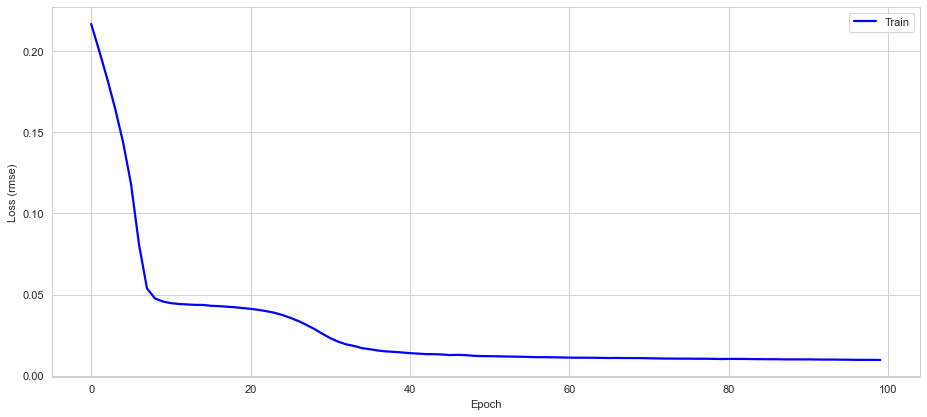

In [58]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
# ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_ylabel('Loss (rmse)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

7/7 [==============================] - 1s 3ms/step


/var/folders/fb/0f4v33f515vfq6921ss69f180000gn/T/ipykernel_29306/167453308.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored['Loss_rmse'], bins=20, kde=True, color='blue')


(0.0, 0.5)

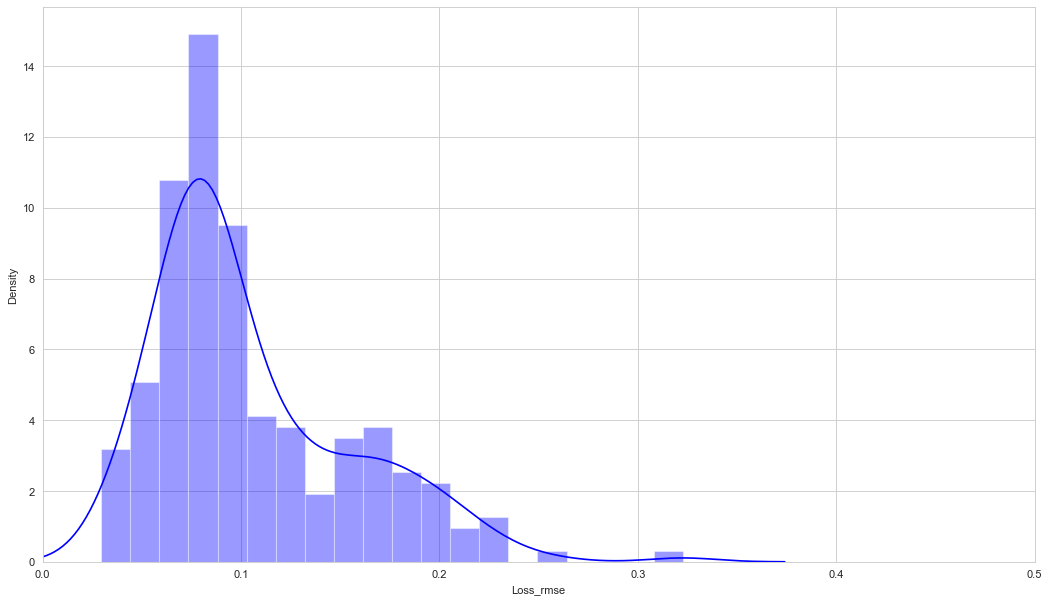

In [59]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=df_train.columns)
X_pred.index = df_train[:-15].index

scored = pd.DataFrame(index=df_train[:-15].index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_rmse'] = np.sqrt(np.mean((X_pred - Xtrain) ** 2, axis=1))
plt.figure(figsize=(16,9), dpi=80)
sns.distplot(scored['Loss_rmse'], bins=20, kde=True, color='blue')
plt.xlim([0.0, 0.5])

In [60]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=df_train.columns)
X_pred.index = df_train[-15:].index

scored = pd.DataFrame(index=df_train[-15:].index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_rmse'] = np.sqrt(np.mean((X_pred - Xtest) ** 2, axis=1))
scored['Threshold'] = 0.2
scored['Anomaly'] = scored['Loss_rmse'] > scored['Threshold']
scored.head()

1/1 [==============================] - 0s 35ms/step


,Loss_rmse,Threshold,Anomaly
Date,,,
2022-12-31,0.336784,0.2,True
2023-01-31,0.344559,0.2,True
2023-02-28,0.347394,0.2,True
2023-03-31,0.352303,0.2,True
2023-04-30,0.342687,0.2,True


In [61]:
# Calculate the same metrics for the training set +
# Merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=df_train[:-15].columns)
X_pred_train.index = df_train[:-15].index

scored_train = pd.DataFrame(index=df_train[:-15].index)
scored_train['Loss_rmse'] = np.sqrt(np.mean((X_pred_train - Xtrain) ** 2, axis=1))
scored_train['Threshold'] = 0.2
scored_train['Anomaly'] = scored_train['Loss_rmse'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])
scored

7/7 [==============================] - 0s 4ms/step


,Loss_rmse,Threshold,Anomaly
Date,,,
2005-01-01,0.146870,0.2,False
2005-02-01,0.162071,0.2,False
2005-03-01,0.130994,0.2,False
2005-04-01,0.128743,0.2,False
2005-05-01,0.157074,0.2,False
...,...,...,...
2023-10-31,0.325397,0.2,True
2023-11-30,0.336360,0.2,True
2023-12-31,0.315424,0.2,True


<Axes: xlabel='Date'>

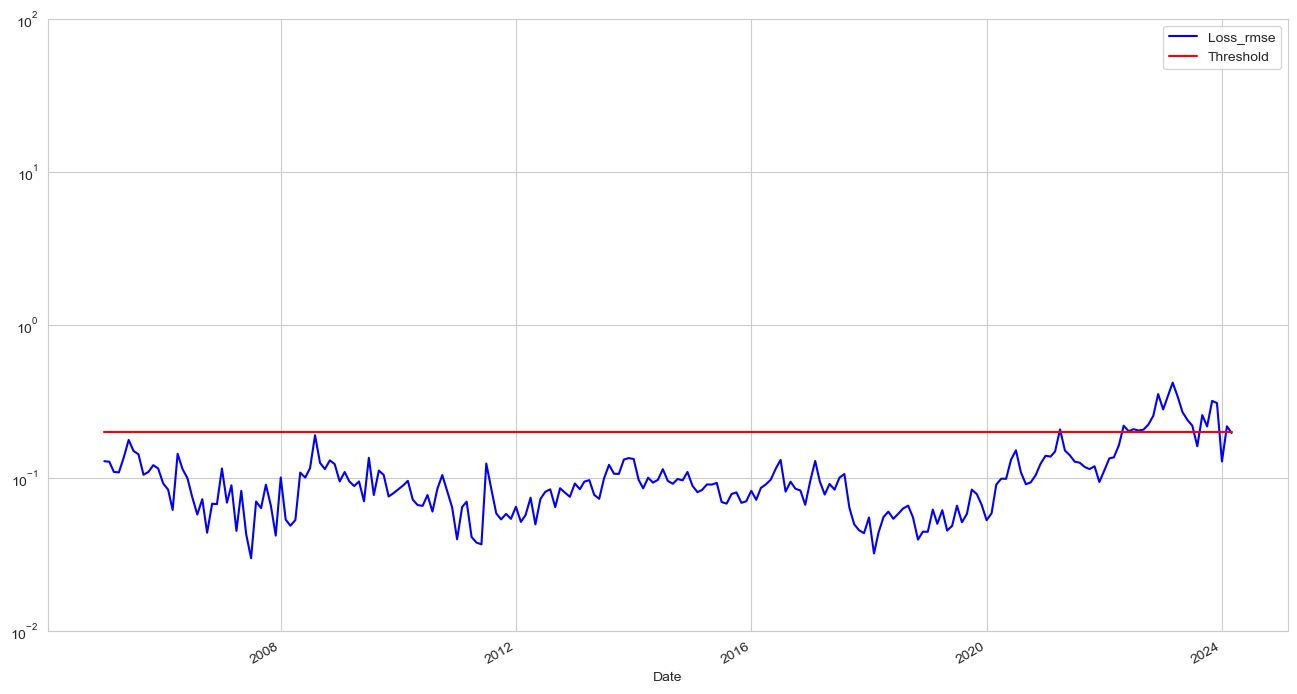

In [62]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])